# Support Vector Classifier

In [1]:
from preprocessing import *
from aux import *
import matplotlib
np.warnings.filterwarnings('ignore')

from sklearn.tree import plot_tree
from sklearn.svm import SVC

sns.set()

df_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1i-KJ2lSvM7OQH0Yd59bX01VoZcq8Sglq')
df_decision = pd.read_csv('https://drive.google.com/uc?export=download&id=1km-AEIMnWVGqMtK-W28n59hqS5Kufhd0')

## Preprocesado

In [2]:
columnillas = ['tipo_de_sala_4d', 'tipo_de_sala_normal', 'tipo_de_sala_nan', 'id_usuario', 'genero_mujer', 'genero_nan', 
              'edad', 'amigos', 'parientes', 'precio_ticket', 
              'nombre_sede_fiumark_palermo', 'nombre_sede_fiumark_quilmes', 'nombre_sede_nan', 
              'cant_acompañantes']

In [3]:
def preprocesado_1(dataset, columnas):
    df = eliminar_features_que_no_aportan_info(dataset, True)
    df = crear_feature_acompañantes(df)
    df = replace_nulls_column(df, 'edad', 'media')
    df = encodear_atributos_categoricos(df)
    df = normalizar_atributos_numericos(df)
    df = df.reindex(columns = columnas)
    return df

In [4]:
volver = ['volveria']
columnas = columnillas + volver

In [5]:
dataset = pd.merge(df_data, df_decision, how='inner', left_on='id_usuario', right_on='id_usuario')

df = preprocesado_1(dataset, columnas)

df.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,amigos,parientes,precio_ticket,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan,cant_acompañantes,volveria
0,1,0,0,0.130337,0,0,0.880653,0.000,0.000000,0.000000,0,1,0,0.0,0.0
1,1,0,0,0.738202,1,0,0.396985,0.125,0.166667,0.020408,0,1,0,0.2,0.0
2,0,1,0,0.891011,0,0,0.368090,0.000,0.000000,0.040816,0,0,0,0.0,0.0
3,1,0,0,0.510112,0,0,0.368090,0.000,0.000000,0.000000,1,0,0,0.0,0.0
4,1,0,0,0.193258,1,0,0.007538,0.125,0.166667,0.020408,1,0,0,0.2,1.0


In [6]:
df.shape

(801, 15)

## Entrenamiento

In [7]:
X, y = split_dataset_X_y(df, columnillas)

params = {'C': np.arange(1, 10), 
          'kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
          'gamma': ['scale', 'auto'],
          'degree': np.arange(3, 10)
         }

model_vector = SVC(probability = True)

best_params, X_train, X_test, y_train, y_test = fit_model_random_grid_search (X, y, model_vector, params)

super_vector = SVC(probability=True,
                   C = best_params['C'],
                   kernel = best_params['kernel'],
                   gamma = best_params['gamma'],
                   degree = best_params['degree'],
                   )

super_vector = apply_stratified_k_fold(X, y, super_vector)

X.shape:  (801, 14)
y.shape:  (801,) 

Best score: 0.8364375273350981
Best params {'kernel': 'rbf', 'gamma': 'auto', 'degree': 3, 'C': 1}

Fold 0: AUC ROC score is 0.7519
Fold 1: AUC ROC score is 0.8126
Fold 2: AUC ROC score is 0.8114
Fold 3: AUC ROC score is 0.7370
Fold 4: AUC ROC score is 0.7482
Mean test AUC ROC is: 0.7722


## Métricas

In [8]:
scores = get_scores(super_vector, X_test, y_test)

AUC ROC : 0.8668
Accuracy : 0.8159
Precision : 0.7761
Recall : 0.8819
F1-Score : 0.7376


## Matriz de confusión

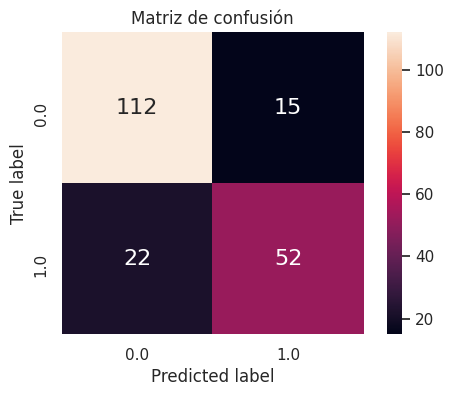

In [9]:
plot_confusion_matrix(y_test, super_vector.predict(X_test))

## Test Holdout

In [10]:
holdout = pd.read_csv('https://drive.google.com/uc?export=download&id=1I980-_K9iOucJO26SG5_M8RELOQ5VB6A')

In [11]:
df_h = preprocesado_1(holdout, columnillas)
df_h.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,amigos,parientes,precio_ticket,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan,cant_acompañantes
0,1,0,0,0.751756,1,0,0.344774,0.0,0.0,0.000000,1,0,0,0.0
1,1,0,0,0.264637,1,0,0.063963,0.5,0.4,0.061224,1,0,0,0.6
2,0,1,0,0.026932,0,0,0.609984,0.0,0.0,0.040816,0,0,0,0.0
3,0,0,0,0.637002,0,0,0.407176,0.0,0.0,0.040816,1,0,0,0.0
4,1,0,0,0.471897,0,0,0.450858,0.0,0.0,0.000000,1,0,0,0.0


In [12]:
df_resultado = evaluate_holdout(holdout, df_h, super_vector)
df_resultado.head(15)

y_pred.shape:  (90,)
holdout_df.shape:  (90, 14) 



,id_usuario,volveria
0,650,1
1,234,1
2,31,0
3,552,0
4,411,0
5,134,1
6,497,1
7,434,0
8,528,0
9,112,1


In [13]:
df_resultado.to_csv('prediccion/SVC_resultado_final.csv')

## Preprocesado 2

In [14]:
columnas_2 = ['tipo_de_sala_4d', 'tipo_de_sala_normal', 'tipo_de_sala_nan', 'id_usuario', 'genero_mujer', 'genero_nan', 
              'edad',
              'nombre_sede_fiumark_palermo', 'nombre_sede_fiumark_quilmes', 'nombre_sede_nan']

In [15]:
def preprocesado_2(dataset, columnas):
    df = eliminar_features_que_no_aportan_info(dataset, True)
    df = eliminar_feature(df,'amigos')
    df = eliminar_feature(df,'parientes')
    df = eliminar_feature(df,'precio_ticket')
    df = replace_nulls_column(df, 'edad', 'media')
    df = encodear_atributos_categoricos(df)
    df = normalizar_atributos_numericos(df)
    df = df.reindex(columns = columnas)
    return df

In [16]:
df_2 = preprocesado_2(dataset, columnas_2+volver)
df_2.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan,volveria
0,1,0,0,0.130337,0,0,0.880653,0,1,0,0.0
1,1,0,0,0.738202,1,0,0.396985,0,1,0,0.0
2,0,1,0,0.891011,0,0,0.368090,0,0,0,0.0
3,1,0,0,0.510112,0,0,0.368090,1,0,0,0.0
4,1,0,0,0.193258,1,0,0.007538,1,0,0,1.0


In [17]:
df_2.shape

(801, 11)

# Entrenamiento

In [19]:
X_2, y_2 = split_dataset_X_y(df_2, columnas_2)

model_vector = SVC(probability = True)

best_params_2, X_train_2, X_test_2, y_train_2, y_test_2 = fit_model_random_grid_search (X_2, y_2, model_vector,
                                                                                        params)

super_vector_2 = SVC(probability=True,
                   C = best_params_2['C'],
                   kernel = best_params_2['kernel'],
                   gamma = best_params_2['gamma'],
                   degree = best_params_2['degree'],
                   )

super_vector_2 = apply_stratified_k_fold(X_2, y_2, super_vector_2)

X.shape:  (801, 10)
y.shape:  (801,) 

Best score: 0.841040252676485
Best params {'kernel': 'rbf', 'gamma': 'auto', 'degree': 8, 'C': 3}

Fold 0: AUC ROC score is 0.7197
Fold 1: AUC ROC score is 0.7894
Fold 2: AUC ROC score is 0.8209
Fold 3: AUC ROC score is 0.7370
Fold 4: AUC ROC score is 0.7860
Mean test AUC ROC is: 0.7706


## Métricas

In [20]:
scores_2 = get_scores(super_vector_2, X_test_2, y_test_2)

AUC ROC : 0.8749
Accuracy : 0.8408
Precision : 0.9200
Recall : 0.9685
F1-Score : 0.7419


### Matriz de confusión

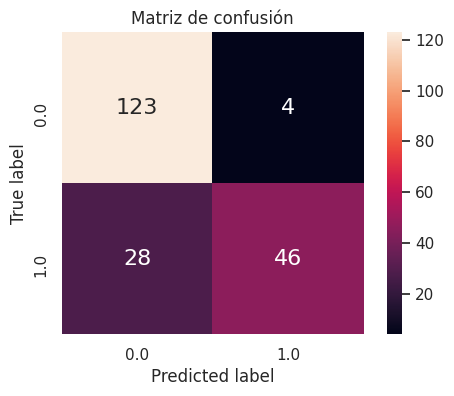

In [21]:
plot_confusion_matrix(y_test_2, super_vector_2.predict(X_test_2))

## Test Holdout

In [22]:
df_h_2 = preprocesado_2(holdout, columnas_2)
df_h_2.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan
0,1,0,0,0.751756,1,0,0.344774,1,0,0
1,1,0,0,0.264637,1,0,0.063963,1,0,0
2,0,1,0,0.026932,0,0,0.609984,0,0,0
3,0,0,0,0.637002,0,0,0.407176,1,0,0
4,1,0,0,0.471897,0,0,0.450858,1,0,0


In [23]:
df_resultado_2 = evaluate_holdout(holdout, df_h_2, super_vector_2)
df_resultado_2.head(15)

y_pred.shape:  (90,)
holdout_df.shape:  (90, 10) 



,id_usuario,volveria
0,650,0
1,234,0
2,31,0
3,552,0
4,411,0
5,134,1
6,497,1
7,434,0
8,528,0
9,112,1


In [24]:
df_resultado_2.to_csv('prediccion/SVC_2do_prepoc_resultado_final.csv')